In [ ]:
# imports
import collections
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import re
import tensorflow as tf
import tqdm
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
# bash code to mount the drive
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('drive/MyDrive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
bible = open('bible.txt', 'r')
text = bible.read()
len(text)

4332496

In [ ]:
## stopwords
stopwords = nltk.corpus.stopwords.words('english')

## some training settings
training_steps = 1000
skip_step = 100

## some hyperparameters
batch_size = 64
embed_size = 64
num_sampled = 256
learning_rate = 1.0

# validation set
valid = ['holy', 'father', 'wine', 'poison', 'love', 'strong', 'day']

In [ ]:
def normalizeText(text):
  # Lower Case
  text = text.lower()
  # Remove Linebreaks and extra whitespace
  text = text.replace("\n\n", "").replace("\n", " ").replace("  ", " ")
  # remove special characters
  text = re.sub(r"[^\w\s]", "", text)
  # remove numbers
  text = re.sub(r"[0-9]", "", text)

  # tokenize text
  text = text.split()

  # remove stopwords
  text = [w for w in text if w not in stopwords]


  return text

In [ ]:
# Build the dictionary and replace rare words with UNK token.
def build_dataset(words, n_words):
    """ Create two dictionaries and count of occuring words
        - word_to_id: map of words to their codes
        - id_to_word: maps codes to words (inverse word_to_id)
        - count: map of words to count of occurrences
    """
    # map unknown words to -1
    count = [['UNK', -1]]
    # count of occurences for words in vocabulary
    count.extend(collections.Counter(words).most_common(n_words - 1)) 
    word_to_id = dict() # (word, id)
    # record word id
    for word, _ in count:
        word_to_id[word] = len(word_to_id)
    id_to_word = dict(zip(word_to_id.values(), word_to_id.keys())) # (id, word)
    return word_to_id, id_to_word, count

def convert_words_to_id(words, dictionary, count):
    """ Replace each word in the dataset with its index in the dictionary """
    data_w2id = []
    unk_count = 0
    for word in words:
        # return 0 if word is not in dictionary
        index = dictionary.get(word, 0)
        if index == 0:
            unk_count += 1
        data_w2id.append(index)
    count[0][1] = unk_count
    return data_w2id, count

In [ ]:
"""Filling 4 global variables:
# data_w2id - list of codes (integers from 0 to vocabulary_size-1).
              This is the original text but words are replaced by their codes
# count - map of words(strings) to count of occurrences
# word_to_id - map of words(strings) to their codes(integers)
# id_to_word - maps codes(integers) to words(strings)
"""

vocabulary_size = 10000
vocabulary = normalizeText(text)
word_to_id, id_to_word, count = build_dataset(vocabulary, vocabulary_size)
data_w2id, count = convert_words_to_id(vocabulary, word_to_id, count)

In [ ]:
print('Most common words (+UNK)', count[:5])
print('Sample data: {}'.format(data_w2id[:10]))
print([id_to_word[i] for i in data_w2id[:10]])

Most common words (+UNK) [['UNK', 2693], ('shall', 9838), ('unto', 8997), ('lord', 7827), ('thou', 5473)]
Sample data: [135, 301, 63, 87, 8574, 573, 6, 1188, 96, 46]
['first', 'book', 'moses', 'called', 'genesis', 'beginning', 'god', 'created', 'heaven', 'earth']


In [ ]:
# utility function
def generate_sample(center_words, context_window_size):
    """ Form training pairs according to the skip-gram model. """
    for idx, center in enumerate(center_words):
        for context in range(context_window_size):
          # get a random target before the center word
          for target in center_words[max(0, idx - context) : idx]:
              yield center, target
          # get a random target after the center word
          for target in center_words[idx + 1 : idx + context + 1]:
              yield center, target

def batch_generator(data, skip_window, batch_size):
    """ Group a numeric stream into batches and yield them as Numpy arrays. """
    single_gen = generate_sample(data, skip_window)
    while True:
        center_batch = np.zeros(batch_size, dtype=np.int32)
        target_batch = np.zeros([batch_size, 1], dtype=np.int32)
        for idx in range(batch_size):
            center_batch[idx], target_batch[idx] = next(single_gen)
        yield center_batch, target_batch



In [ ]:
from tensorflow.keras.layers import Layer

# embedding matrix - hidden layer
class SkipGram(Layer):
    def __init__(self):
        super(SkipGram, self).__init__()
        embedding_init = tf.keras.initializers.GlorotUniform()
        self.embedding_matrix = self.add_weight(name="embedding_matrix",
                                                trainable=True,
                                                shape=[vocabulary_size, embed_size],
                                                initializer=embedding_init)
        nce_w_init = tf.keras.initializers.TruncatedNormal(stddev=1.0/(embed_size ** 0.5))
        self.nce_weight = self.add_weight(name='nce_weight',
                                          trainable=True,
                                          shape=[vocabulary_size, embed_size],
                                          initializer=nce_w_init)
        self.nce_bias = self.add_weight(name='nce_bias',
                                        trainable=True,
                                        shape=[vocabulary_size],
                                        initializer=tf.keras.initializers.Zeros)

    def call(self, inputs, targets):
        center_words = inputs
        target_words = targets
        embedding = tf.nn.embedding_lookup(self.embedding_matrix,
                                           center_words, 
                                           name='embedding')
        loss = tf.reduce_mean(tf.nn.nce_loss(weights=self.nce_weight, 
                                             biases=self.nce_bias, 
                                             labels=target_words, 
                                             inputs=embedding, 
                                             num_sampled=num_sampled, 
                                             num_classes=vocabulary_size),
                                             name='loss')
        return loss

In [ ]:
from tensorflow.keras import Model, Input

center_words = Input(shape=(), name='center_words', dtype='int32')
target_words = Input(shape=(1), name='target_words', dtype='int32')

loss = SkipGram() (center_words, target_words)

word2vec = Model(name='word2vec',
                 inputs=[center_words, target_words],
                 outputs=[loss])

In [ ]:
word2vec.summary()

Model: "word2vec"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 center_words (InputLayer)      [(None,)]            0           []                               
                                                                                                  
 target_words (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 skip_gram (SkipGram)           ()                   1290000     ['center_words[0][0]',           
                                                                  'target_words[0][0]']           
                                                                                                  
Total params: 1,290,000
Trainable params: 1,290,000
Non-trainable params: 0
_______________

In [ ]:
## geneartor for `tf.data.Dataset`
def gen():
    """ Return a python generator that generates batches. """
    yield from batch_generator(data_w2id, 2, batch_size)

    

dataset = tf.data.Dataset.from_generator(gen, 
                                         (tf.int32, tf.int32),
                                         (tf.TensorShape([batch_size]), tf.TensorShape([batch_size, 1])))\
                         .repeat()

In [ ]:
train_loss = tf.keras.metrics.Mean(name='train_loss')
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.1,nesterov=True)

In [ ]:
@tf.function
def train_step(center_words, target_words):
    with tf.GradientTape() as tape:
        loss = word2vec([center_words, target_words])
    gradients = tape.gradient(loss, word2vec.trainable_variables)
    optimizer.apply_gradients(zip(gradients, word2vec.trainable_variables))

    train_loss(loss)

In [ ]:
import numpy.linalg as LA


# handy method for calculating the similarity between 2 word
def cos_sim(word1, word2):
    id1 = word_to_id[word1]
    id2 = word_to_id[word2]
    
    vec1 = embedding_matrix[id1].numpy()
    vec2 = embedding_matrix[id2].numpy()

    return np.dot(vec1, vec2) / (LA.norm(vec1) * LA.norm(vec2))



In [ ]:
def top_k_nearest(word, k):
    if word in word_to_id.keys():
      vec = embedding_matrix[word_to_id[word]]
    else:
      print('{} is unknown'.format(word))
      word = 'UNK'
      vec = embedding_matrix[word_to_id[word]]
    
    # calaulate cosine similarity  of `vec` and all other vocabularies
    dot = np.dot(embedding_matrix.numpy(), vec)
    embedding_norm = LA.norm(embedding_matrix.numpy(), axis=-1)
    vec_norm = LA.norm(vec)
    norm_product = embedding_norm * vec_norm
    cos_sim = dot / norm_product
    
    # print out top k nearest words
    indices = np.argsort(cos_sim)[::-1][1:k+1]
    print('---top {} nearest words of {}---'.format(k, word))
    for idx in indices:
        print(id_to_word[idx])



In [ ]:
x = []
y = []
dataset.shuffle(10000)
for step, (center_words, target_words) in enumerate(dataset):
    if step == training_steps:
        break
    train_step(center_words, target_words)

    if ((step+1) % skip_step) == 0:
      template = 'Step {:0}, Loss: {:.2f}'
      x.append(step+1)
      y.append(train_loss.result())
      print (template.format(step+1, train_loss.result()))
      train_loss.reset_states()

      embedding_matrix = word2vec.weights[0]
      for word in valid:
        top_k_nearest(word, 5)

Step 100, Loss: 333.78
---top 5 nearest words of holy---
appetite
undo
lawgiver
dealers
wheresoever
---top 5 nearest words of father---
zillah
ham
wise
sewed
lamech
---top 5 nearest words of wine---
established
overspread
drank
vineyard
husbandman
---top 5 nearest words of poison---
threescore
armenia
vigilant
heareth
nergalsharezer
---top 5 nearest words of love---
horrible
heir
wonderful
lendeth
austere
---top 5 nearest words of strong---
sixscore
archangel
ammonite
rememberest
protection
---top 5 nearest words of day---
made
blessed
ended
heavens
work
Step 200, Loss: 156.09
---top 5 nearest words of holy---
appetite
undo
lawgiver
dealers
wheresoever
---top 5 nearest words of father---
taken
cleave
mother
wives
bone
---top 5 nearest words of wine---
established
drank
overspread
stay
vineyard
---top 5 nearest words of poison---
threescore
armenia
vigilant
heareth
nergalsharezer
---top 5 nearest words of love---
horrible
wonderful
lendeth
austere
advantage
---top 5 nearest words of str

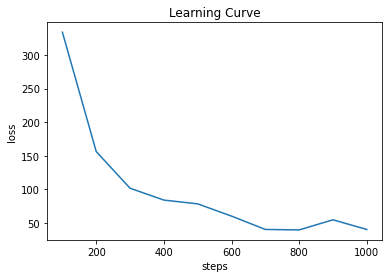

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.xlabel("steps")
plt.ylabel("loss")
plt.title("Learning Curve")
plt.plot(x, y)
plt.show()



In [ ]:


def plot_with_labels(low_dim_embs, labels):
    assert low_dim_embs.shape[0] >= len(labels), 'More labels than embeddings'
    plt.figure(figsize=(18, 18), dpi=150)  # in inches
    for i, label in enumerate(labels):
        x, y = low_dim_embs[i, :]
        plt.scatter(x, y)
        plt.annotate(
            label,
            xy=(x, y),
            xytext=(5, 2),
            textcoords='offset points',
            ha='right',
            va='bottom')



/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:986: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  FutureWarning,


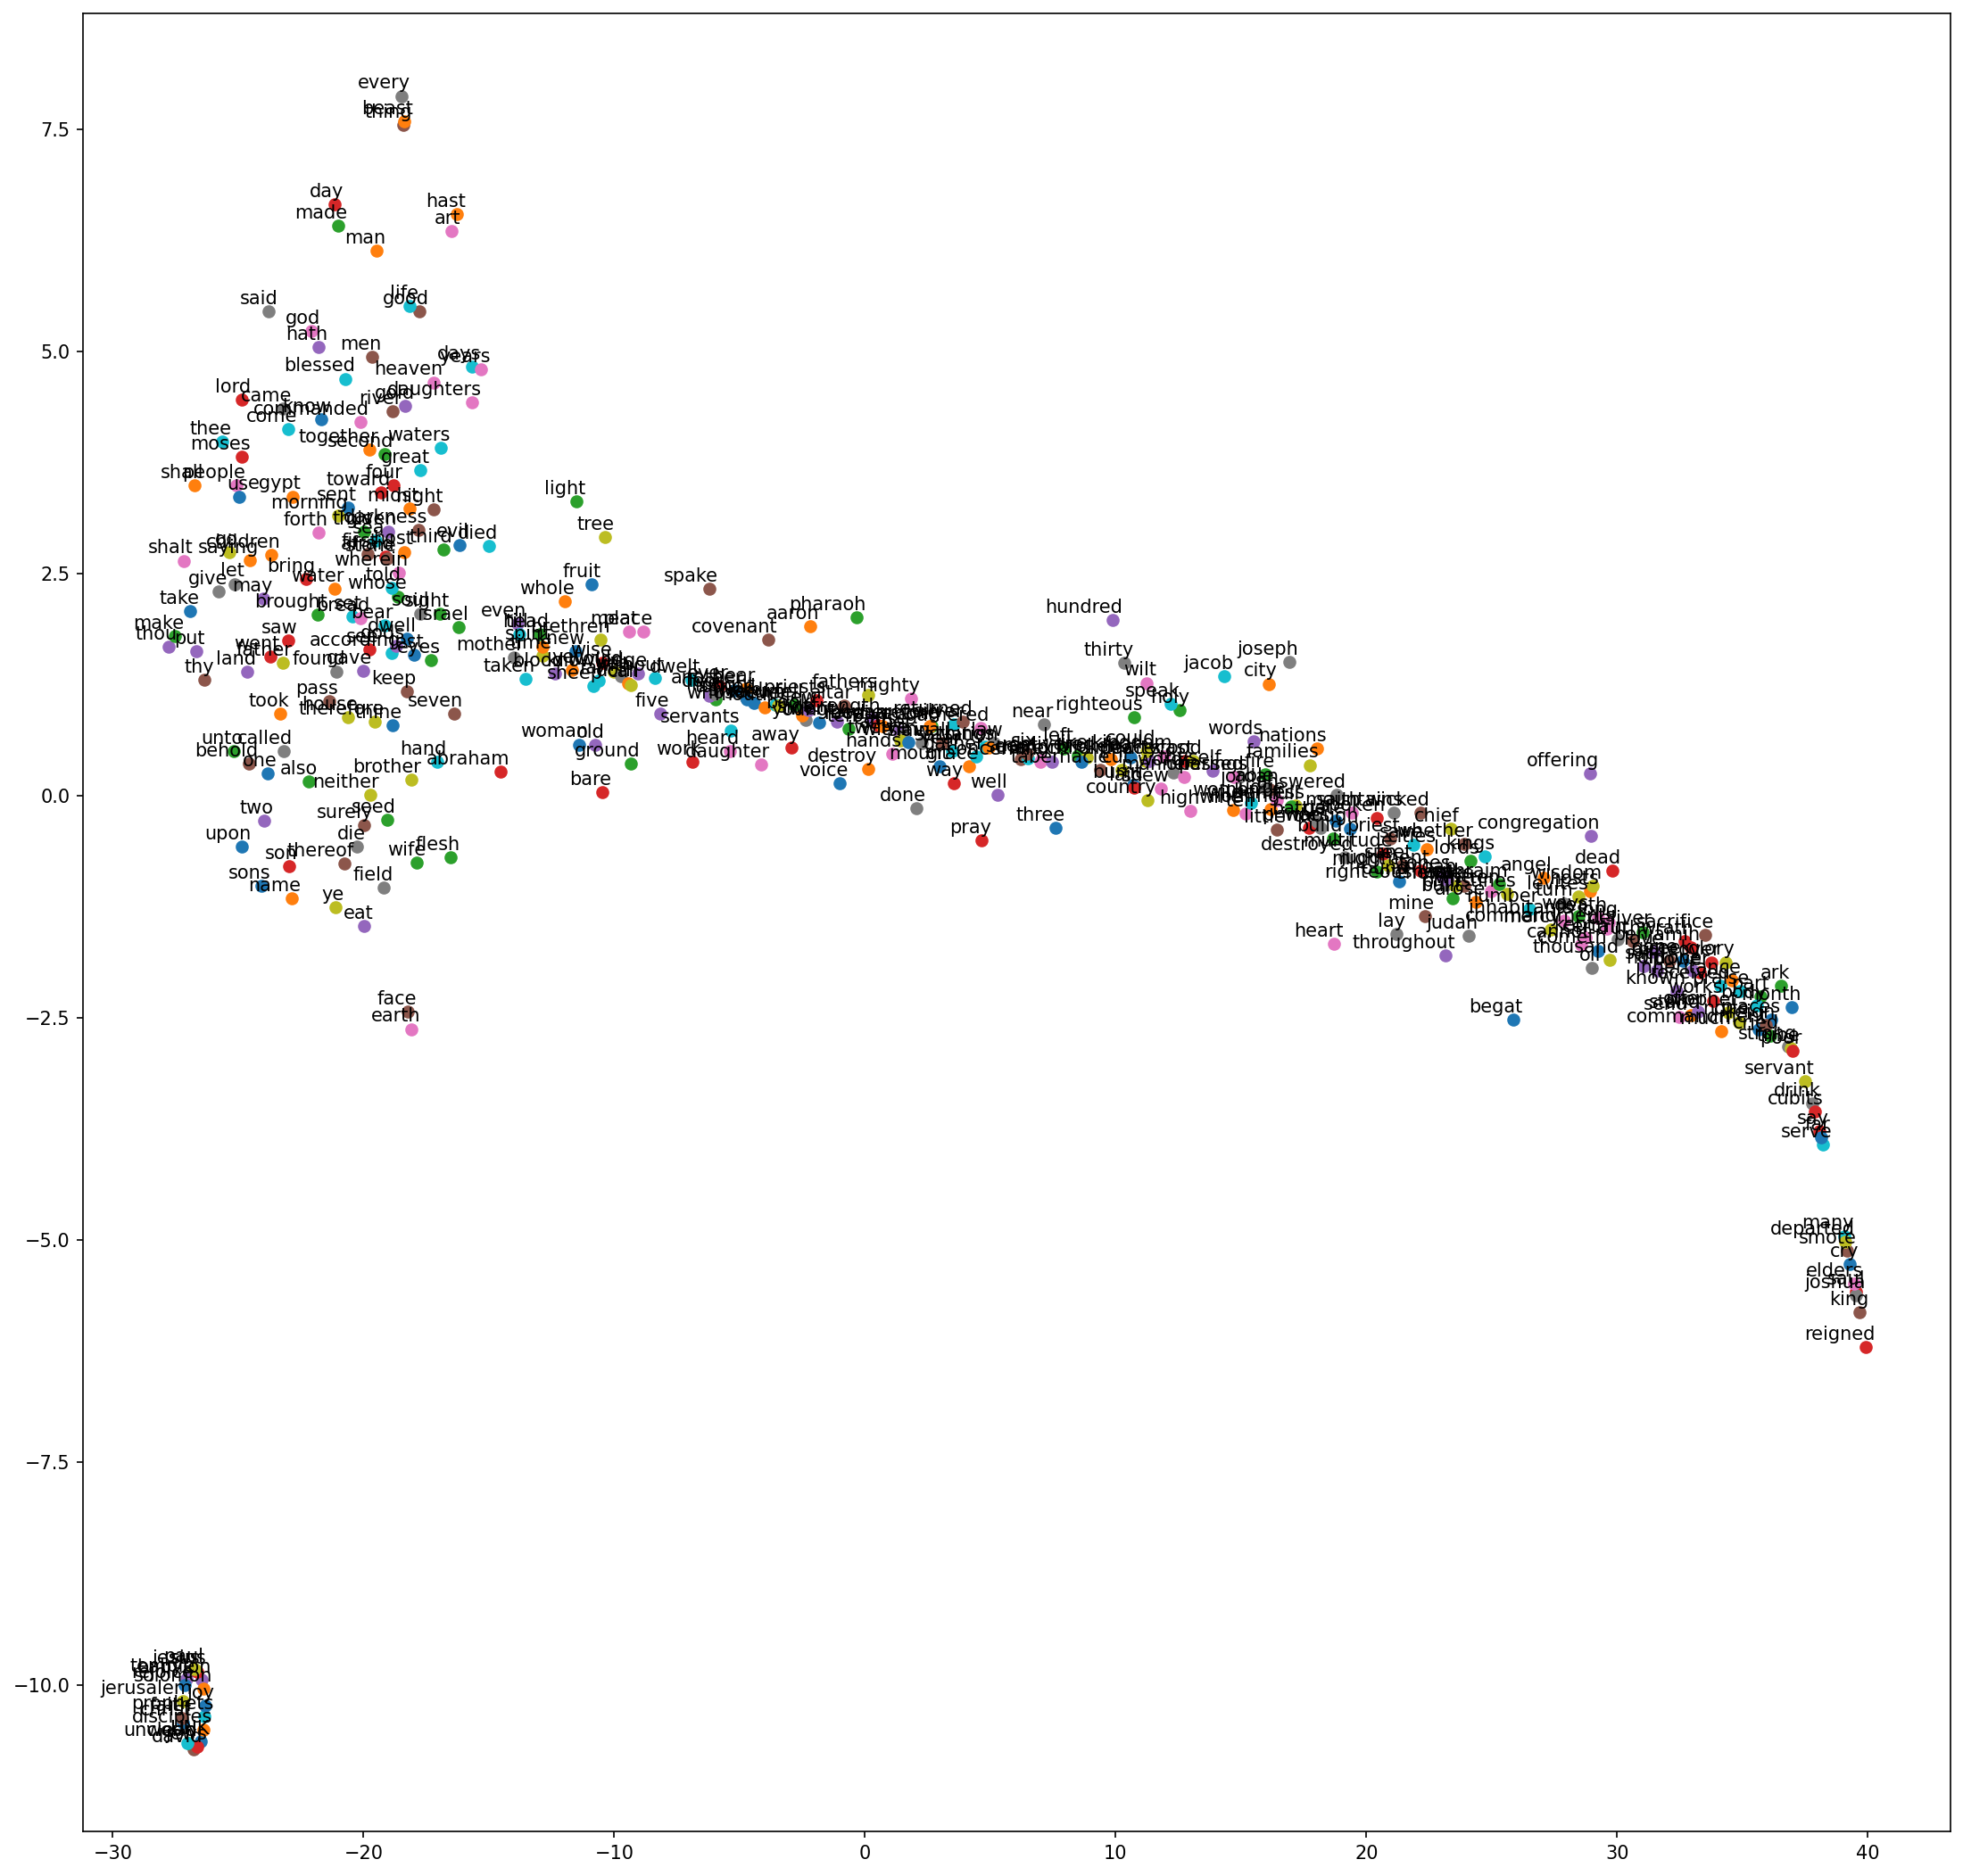

In [ ]:


from sklearn.manifold import TSNE

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact', learning_rate='auto')
plot_only = 400
final_embeddings = embedding_matrix
low_dim_embs = tsne.fit_transform(final_embeddings[:plot_only, :])
labels = [id_to_word[i] for i in range(plot_only)]
plot_with_labels(low_dim_embs, labels)

